In [1]:
import sys

import pandas as pd
import matplotlib.pyplot as plt

from pprint import pprint

In [2]:
from pydantic import BaseModel
import numpy as np

In [3]:
sys.path.append("../")
sys.path.append("../LOCOinPython/")
sys.path.append("../Tracking_with_imperfections/")

In [4]:
from utils import apply_kicks, get_optics, read_tracking_file, plot_optics, plot_dynap, create_err_table, match_optics, correct_orbit, get_ptc_optics

In [5]:
from LOCOinPython.src.file_loader.structure_loader import read_structure
from LOCOinPython.src.numerical_model.orbit_correction import OrbitCorrectionSVD
from LOCOinPython.src.numerical_model.response_matrix import run_madx
from LOCOinPython.src.numerical_model.lattice_correction import LatticeCorrection

# Structure loading

In [6]:
file = "structures/Ring_DD.seq"
structure = read_structure(file, energy=3)

file = "structures/Ring_DD_nosext_norf.seq"
structure_nosext_norf = read_structure(file, energy=3)

file = "structures/Ring_DD_nosext.seq"
structure_nosext = read_structure(file, energy=3)

file = "structures/Ring_DD_one_period.seq"
structure_one_period = read_structure(file, energy=3)

file = "structures/Ring_DD_one_period_no_sext.seq"
structure_one_period_no_sext = read_structure(file, energy=3)

Structure in the JSON format already exists
Structure in the JSON format already exists
Structure in the JSON format already exists
Structure in the JSON format already exists
Structure in the JSON format already exists


# Ideal structure

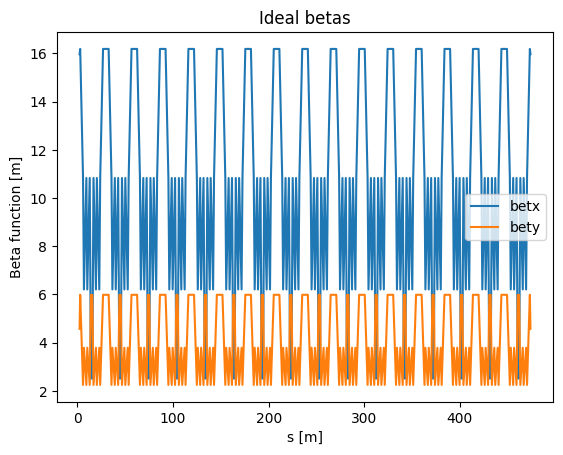

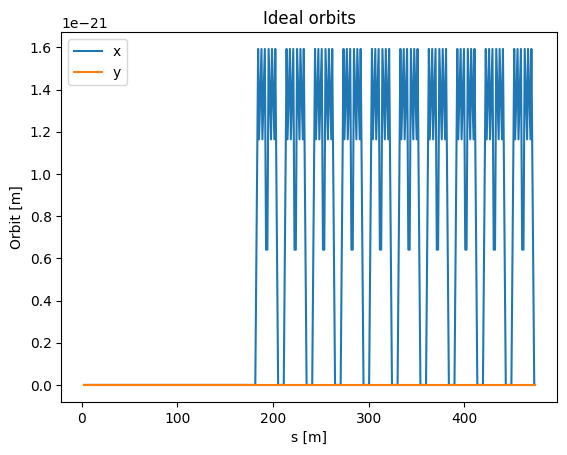

In [14]:
init_optics = get_optics(structure)
plot_optics(init_optics, params_to_show="beta", title="Ideal betas")
plt.show()

plot_optics(init_optics, params_to_show="orbit", title="Ideal orbits")
plt.show()

 21%|██████████████▎                                                      | 500009/2407417 [00:01<00:05, 332762.34it/s]
1799it [00:00, 508083.83it/s]


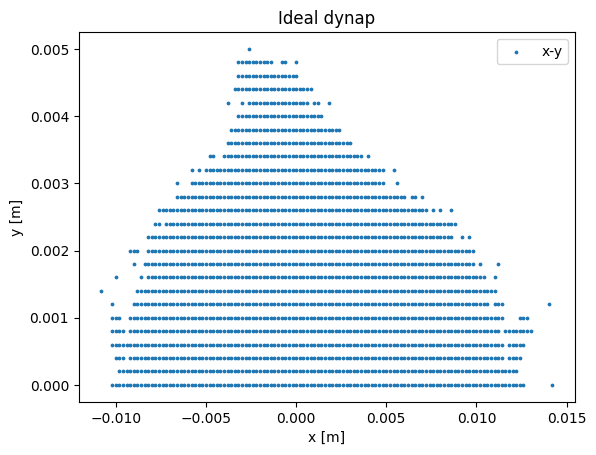

In [15]:
params = {"x": "m",
          "y": "m"}
tab_ideal = read_tracking_file("tracking_data/tracking_skif_xy_1000one.txt", unlost_only=True)
plot_dynap(tab_ideal, params, title="Ideal dynap", plot_name="x-y")
plt.show()

# Elements definition

In [16]:
elems_with_errs = []
for i in structure["elements"]:
    if structure["elements"][i]["type"] not in ["marker", "rfcavity"]:
        i_ = i.split(".")
        if len(i_) == 3:
            i_ = ".".join(i_[:-1])
            if i_ not in elems_with_errs:
                elems_with_errs.append(i_)
        else:
            elems_with_errs.append(i)
hcorrs = {i: {"type": "hkicker"} for i in structure["elements"] if structure["elements"][i]["type"] in ["hkicker"]}
vcorrs = {i: {"type": "vkicker"} for i in structure["elements"] if structure["elements"][i]["type"] in ["vkicker"]}
corrs = {"hkicker": hcorrs, "vkicker": vcorrs}
quads = [i for i in structure["elements"] if structure["elements"][i]["type"] in ["quadrupole"]]
bpms = [i for i in structure["elements"] if structure["elements"][i]["type"] in ["monitor"]]
mult_quads = [i for i in structure["elements"] if structure["elements"][i]["type"] in ["multipole"] and i.endswith(".cg")]
mult_skew_quads = [i for i in structure["elements"] if structure["elements"][i]["type"] in ["multipole"] and i.endswith(".cc")]

# elems_for_matching = {quad: "k1" for quad in quads}
# elems_for_matching.update({corr: "kick" for corr in hcorrs})
# elems_for_matching.update({corr: "kick" for corr in vcorrs})

elems_for_matching = {quad: "k1" for quad in quads + mult_quads}
elems_for_matching.update({skew_quad: "k1s" for skew_quad in mult_skew_quads})

structure["kick"] = corrs
structure["kick_total"] = corrs
print(len(elems_with_errs))

979


In [9]:
print(len(elems_for_matching))

643


In [17]:
align_errs = create_err_table(["dx", "dy", "ds", "dpsi", "dphi", "dtheta"], elems_with_errs, seed=42)
# align_errs = create_err_table(["dx", "dy", "dpsi"], elems_with_errs, seed=42)

# Optics with all kind imperfections, sextupoles off, rf off

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:13<00:00,  2.32s/it]


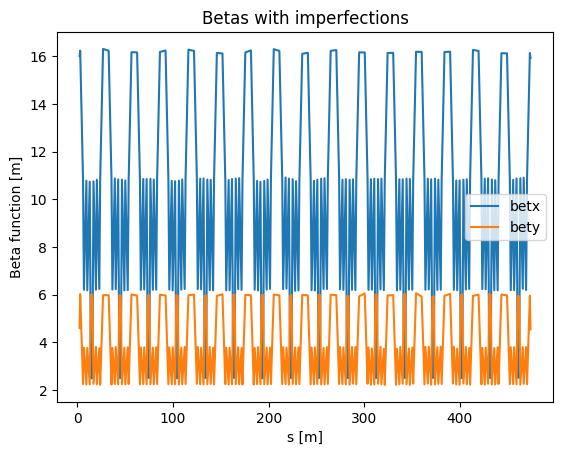

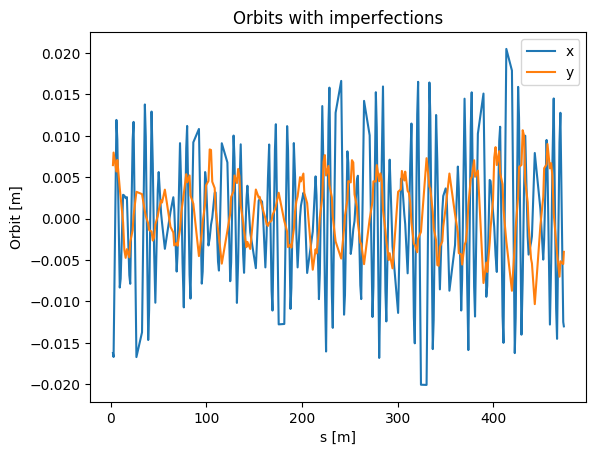

In [10]:
interim_optics_nosext = get_optics(structure_nosext_norf, aligns=align_errs, verbose=True)
plot_optics(interim_optics_nosext, params_to_show="beta", title="Betas with imperfections")
plt.show()

plot_optics(interim_optics_nosext, params_to_show="orbit", title="Orbits with imperfections")
plt.show()

 16%|███████████▎                                                         | 500009/3063646 [00:01<00:07, 341014.39it/s]
2it [00:00, 603.15it/s]


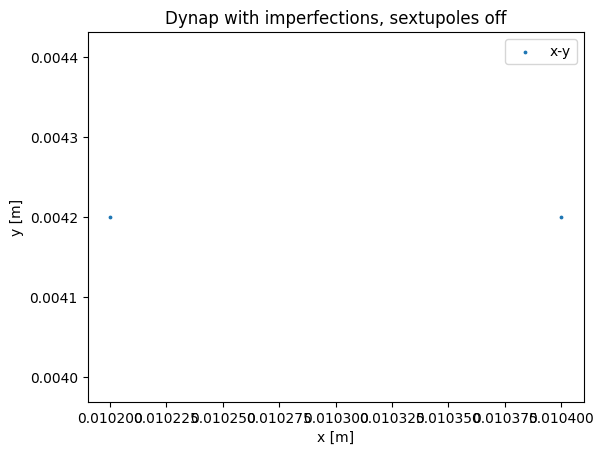

In [11]:
params = {"x": "m",
          "y": "m"}
tab_err = read_tracking_file("tracking_data/tracking_xy_nosext_norad_1000one.txt", unlost_only=True)
plot_dynap(tab_err, params, title="Dynap with imperfections, sextupoles off", plot_name="x-y")
plt.show()

## Orbit correction with LOCO

In [13]:
orm, tunes = run_madx(structure_nosext, {}, kick_value=0.00001)
total_hkicker = len(hcorrs)
total_vkicker = len(vcorrs)
total_bpms = len(structure["bpm_total"])
hkicker_matrix = pd.DataFrame(orm[:, :total_hkicker], columns=list(corrs["hkicker"]))
vkicker_matrix = pd.DataFrame(orm[:, total_hkicker:(total_hkicker+total_vkicker)], columns=list(corrs["vkicker"]))
dispersion = pd.DataFrame(orm[:, -1], columns=["dispersion"])
orm = pd.concat([hkicker_matrix, vkicker_matrix, dispersion], axis=1, keys=("hkicker", "vkicker", "dispersion"))
orm.set_axis(2 * structure["bpm_total"], axis=0, copy=False)

0:01:20.221639


hkicker                                                 
            ms1.kic3 ma1.cma1.cx ma1.bma1.cx  ma1.kic4 ma1.sfa1.cx   
ms1.pki2  -11.570944   -7.952544    0.575773  8.482735   10.684579  \
ma1.pka1  -11.564615   -8.260326    0.523477  8.647138   10.931898   
ma1.pkb1   10.950196    8.036437    0.671385 -5.873049   -7.780635   
ma1.pkc1    7.949428    5.870818    0.581562 -4.088879   -5.714042   
ma1.pkd1  -11.668931   -8.382734   -0.259466  7.008723    9.295345   
...              ...         ...         ...       ...         ...   
ma16.pkd4   0.000000    0.000000    0.000000  0.000000    0.000000   
ma16.pkc4   0.000000    0.000000    0.000000  0.000000    0.000000   
ma16.pkb2   0.000000    0.000000    0.000000  0.000000    0.000000   
ma16.pka2   0.000000    0.000000    0.000000  0.000000    0.000000   
ms1.pki1    0.000000    0.000000    0.000000  0.000000    0.000000   

                                                                       ...   
          ma1.sda1.cx ma1.sdb1.cx ma1.sfb1.cx ma1.sdc1.cx ma1.sdd1.cx  ...   
ms1.pki2     6.230281   -7.104742  -11.600400   -7.071729    6.368073  ...  \
ma1.pka1     6.408782   -7.120233  -11.677424   -7.152266    6.274903  ...   
ma1.pkb1    -4.376426    5.777755    9.188358    5.447798   -5.754475  ...   
ma1.pkc1    -3.590407    4.414339    7.098352    4.260676   -4.232157  ...   
ma1.pkd1     5.807644   -4.548117   -7.825325   -4.379269    5.778568  ...   
...               ...         ...         ...         ...         ...  ...   
ma16.pkd4    0.000000    0.000000    0.000000    0.000000    0.000000  ...   
ma16.pkc4    0.000000    0.000000    0.000000    0.000000    0.000000  ...   
ma16.pkb2    0.000000    0.000000    0.000000    0.000000    0.000000  ...   
ma16.pka2    0.000000    0.000000    0.000000    0.000000    0.000000  ...   
ms1.pki1     0.000000    0.000000    0.000000    0.000000    0.000000  ...   

               vkicker                                                       
          ma16.sdd2.cy ma16.sdc2.cy ma16.sfb2.cy ma16.cbb1.cy ma16.sdb2.cy   
ms1.pki2      0.000000     0.000000     0.000000     0.000000     0.000000  \
ma1.pka1      0.000000     0.000000     0.000000     0.000000     0.000000   
ma1.pkb1      0.000000     0.000000     0.000000     0.000000     0.000000   
ma1.pkc1      0.000000     0.000000     0.000000     0.000000     0.000000   
ma1.pkd1      0.000000     0.000000     0.000000     0.000000     0.000000   
...                ...          ...          ...          ...          ...   
ma16.pkd4    -1.321391    -2.036817    -1.905046    -2.232600    -2.572318   
ma16.pkc4     0.492254    -0.575428    -1.330853    -2.379635    -3.154050   
ma16.pkb2     1.658716     0.896248    -0.148263    -0.878319    -1.313043   
ma16.pka2     4.646851     3.768326     1.507892     0.706291     0.452999   
ms1.pki1      4.370511     3.718830     1.685256     1.103998     0.999695   

                                                                 dispersion  
          ma16.sda2.cy ma16.sfa2.cy ma16.cbc1.cy ma16.cma2.cy    dispersion  
ms1.pki2      0.000000     0.000000     0.000000     0.000000 -2.273011e-12  
ma1.pka1      0.000000     0.000000     0.000000     0.000000 -2.273361e-12  
ma1.pkb1      0.000000     0.000000     0.000000     0.000000  5.066535e-02  
ma1.pkc1      0.000000     0.000000     0.000000     0.000000  3.702794e-02  
ma1.pkd1      0.000000     0.000000     0.000000     0.000000  5.066535e-02  
...                ...          ...          ...          ...           ...  
ma16.pkd4    -1.958027    -0.713314     0.379232     1.301722  0.000000e+00  
ma16.pkc4    -3.812901    -2.200624    -1.975409    -1.816273  0.000000e+00  
ma16.pkb2    -2.029820    -1.857023    -2.758784    -3.291003  0.000000e+00  
ma16.pka2    -0.888274    -1.660236    -4.776474    -7.466557  0.000000e+00  
ms1.pki1     -0.169238    -1.069692    -3.700418    -5.967213  0.000000e+00  

[452 rows x 709 columns]

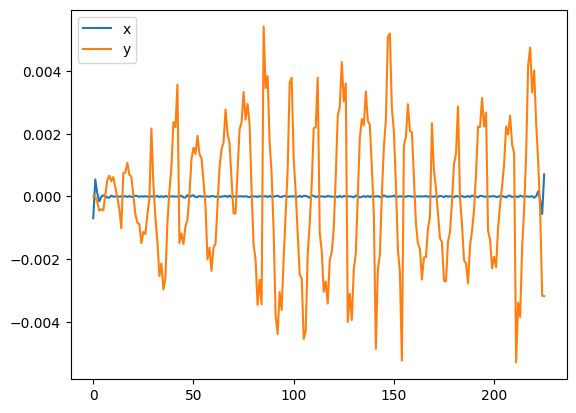

In [36]:
corrs_ = {"hkicker": list(corrs["hkicker"]), "vkicker": list(corrs["vkicker"])}
OrbitCorrectionSVD.SVD_CUTOFF = 1e-3
orbit_correction = OrbitCorrectionSVD(None)
orbit_correction.set_orm(orm)
orbit_correction.set_correctors(corrs_)

kicks, orb = orbit_correction.find_kicks(interim_optics_nosext["x"], interim_optics_nosext["y"], "x")
plt.plot(orb[:total_bpms], label='x')
plt.plot(orb[total_bpms:], label='y')
plt.legend()
plt.show()

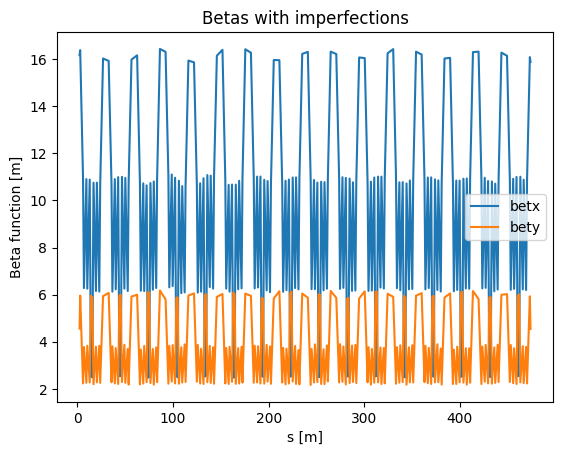

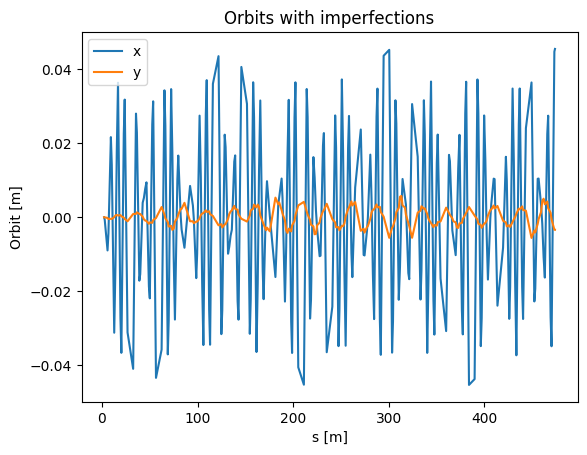

In [37]:
interim_optics_nosext_corrected_orb = get_optics(structure_nosext, 
                                                 imperfections_file="D:/PycharmProjects/SKIF-Lattice-Analysis/imperfections_tables/imperfections_all_aligns.txt", 
                                                 kicks_corrs=kicks, 
                                                 verbose=True)
plot_optics(interim_optics_nosext_corrected_orb, params_to_show="beta", title="Betas with imperfections")
plt.show()

plot_optics(interim_optics_nosext_corrected_orb, params_to_show="orbit", title="Orbits with imperfections")
plt.show()

## Orbit correction with MAD-X funcs

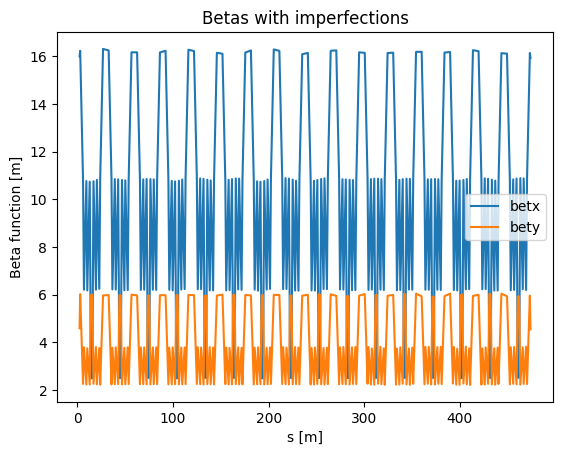

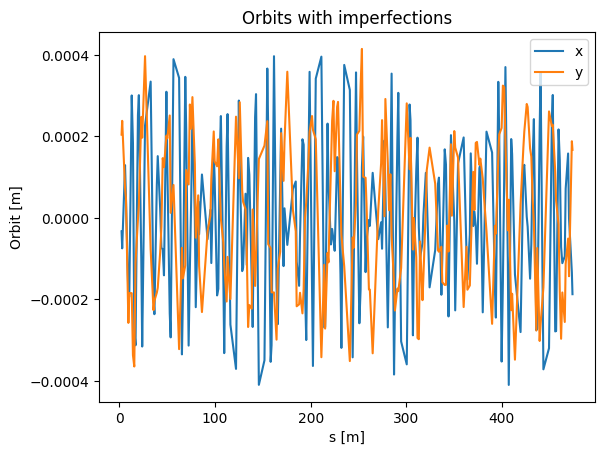

In [12]:
# correct_orbit(structure_nosext_norf, "D:/PycharmProjects/SKIF-Lattice-Analysis/imperfections_tables/imperfections_all_aligns.txt", planes=["x", "y"], algorithm="svd", verbose=True)
# correct_orbit(structure_nosext, aligns=align_errs, ncorrs=64, plane="y", verbose=True)
interim_optics_nosext_corr_orbit = get_optics(structure_nosext_norf, 
                                              imperfections_file="D:/PycharmProjects/SKIF-Lattice-Analysis/imperfections_tables/imperfections_all_aligns.txt", 
                                              file_with_kicks="D:/PycharmProjects/SKIF-Lattice-Analysis/stren1.out", 
                                              verbose=True)
# # # interim_optics_nosext_corr_orbit = get_optics(structure_nosext, aligns=align_errs, file_with_kicks="D:/PycharmProjects/SKIF-Lattice-Analysis/stren.out", verbose=True)

plot_optics(interim_optics_nosext_corr_orbit, params_to_show="beta", title="Betas with imperfections")
plt.show()

plot_optics(interim_optics_nosext_corr_orbit, params_to_show="orbit", title="Orbits with imperfections")
plt.show()

  8%|█████▎                                                               | 500009/6514513 [00:01<00:21, 284785.31it/s]
915it [00:00, ?it/s]


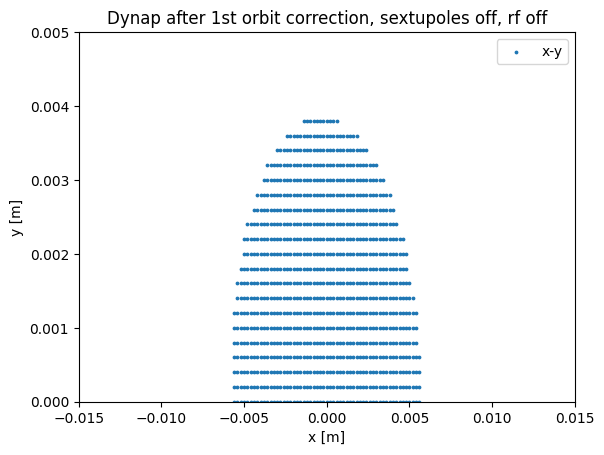

In [23]:
params = {"x": "m",
          "y": "m"}
tab_after = read_tracking_file("tracking_data/trackingXY_norad_nosext_norf_allAligns_kicksOn_matchedOff_1000one.txt", unlost_only=True)
plot_dynap(tab_after, params, title="Dynap after 1st orbit correction, sextupoles off, rf off", plot_name="x-y", x_limits=[-0.015, 0.015], y_limits=[0, 0.005])
plt.show()

## Matching

In [18]:
steps_for_matching = {"k1": 1e-3, "kick": 1e-4, "k1s": 1e-3}
interim_optics_nosext_matched, match_res = match_optics(structure_nosext_norf, 
                                                        aligns=align_errs, 
                                                        target_vars=["betx", "bety", "dx"], 
                                                        target_optical_funcs=init_optics, 
                                                        elem_and_params_to_match=elems_for_matching, 
                                                        param_steps=steps_for_matching, 
                                                        algorithms=["lmdif"], 
                                                        file_with_kicks="D:/PycharmProjects/SKIF-Lattice-Analysis/stren1.out", 
                                                        verbose=True, 
                                                        save_matching=False, 
                                                        file_to_save=None)

plot_optics(interim_optics_nosext_matched, params_to_show="beta", title="Betas with imperfections")
plt.show()

plot_optics(interim_optics_nosext_matched, params_to_show="orbit", title="Orbits with imperfections")
plt.show()

ma1.sfa1.cc: multipole;
ma1.cma1.cc: multipole;
ma1.sfa1.cg: multipole; ma1.sfa1.cg


ValueError: Check multipole definition: ma1.sfa1.cg: multipole;. Desired form: multipole, knl={...}

## Optics after orbit and structure correction, sextupoles off, rf off

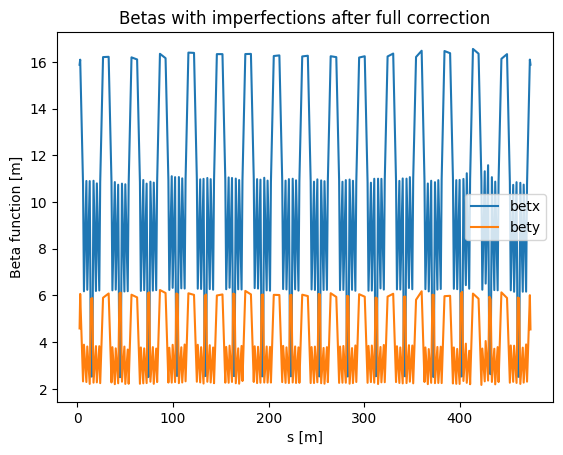

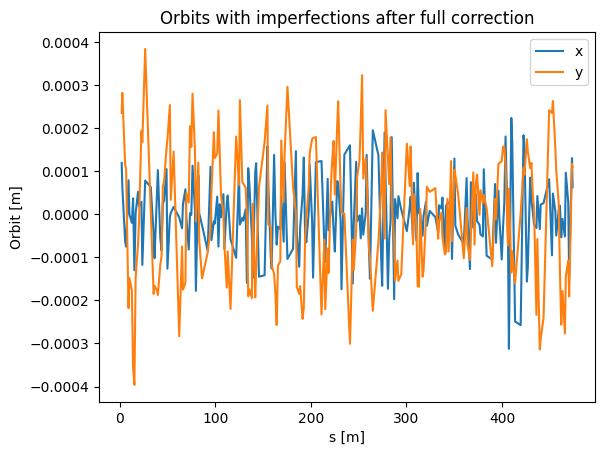

In [20]:
optics_after_correction = get_optics(structure_nosext_norf, 
                                     imperfections_file="D:/PycharmProjects/SKIF-Lattice-Analysis/imperfections_tables/imperfections_all_aligns.txt", 
                                     file_with_kicks="D:/PycharmProjects/SKIF-Lattice-Analysis/stren1.out",
                                     file_with_matching_results="D:/PycharmProjects/SKIF-Lattice-Analysis/match_res1.txt",
                                     verbose=True)

plot_optics(optics_after_correction, params_to_show="beta", title="Betas with imperfections after full correction")
plt.show()

plot_optics(optics_after_correction, params_to_show="orbit", title="Orbits with imperfections after full correction")
plt.show()

  8%|█████▋                                                               | 500009/6004044 [00:01<00:21, 256336.17it/s]
839it [00:00, ?it/s]


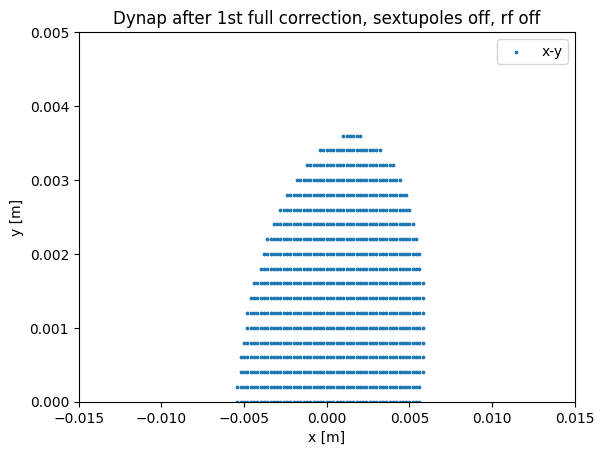

In [12]:
params = {"x": "m",
          "y": "m"}
tab_after_matching = read_tracking_file("tracking_data/trackingXY_norad_nosext_norf_allAligns_kicksOn_matchedOn_1000one.txt", unlost_only=True)
plot_dynap(tab_after_matching, params, title="Dynap after 1st full correction, sextupoles off, rf off", plot_name="x-y", x_limits=[-0.015, 0.015], y_limits=[0, 0.005])
plt.show()

## Optics after orbit and structure correction, sextupoles off, rf on

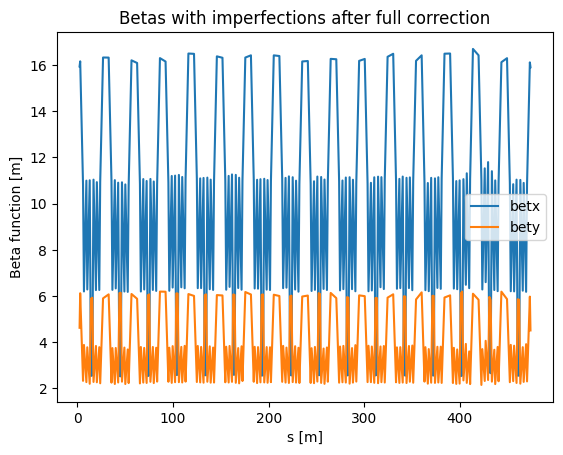

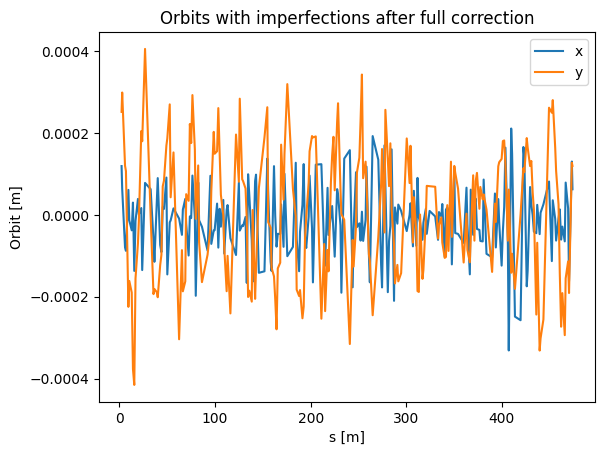

In [22]:
optics_after_correction = get_optics(structure_nosext, 
                                     imperfections_file="D:/PycharmProjects/SKIF-Lattice-Analysis/imperfections_tables/imperfections_all_aligns.txt", 
                                     file_with_kicks="D:/PycharmProjects/SKIF-Lattice-Analysis/stren1.out",
                                     file_with_matching_results="D:/PycharmProjects/SKIF-Lattice-Analysis/match_res1.txt",
                                     verbose=True)

plot_optics(optics_after_correction, params_to_show="beta", title="Betas with imperfections after full correction")
plt.show()

plot_optics(optics_after_correction, params_to_show="orbit", title="Orbits with imperfections after full correction")
plt.show()

 15%|██████████▍                                                          | 500009/3297510 [00:01<00:08, 345484.56it/s]
11it [00:00, ?it/s]


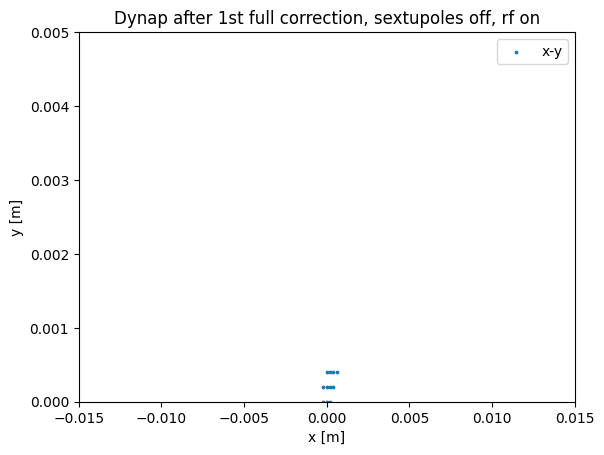

In [17]:
params = {"x": "m",
          "y": "m"}
tab_after_matching = read_tracking_file("tracking_data/trackingXY_norad_nosext_allAligns_kicksOn_matchedOn_1000one.txt", unlost_only=True)
plot_dynap(tab_after_matching, params, title="Dynap after 1st full correction, sextupoles off, rf on", plot_name="x-y", x_limits=[-0.015, 0.015], y_limits=[0, 0.005])
plt.show()

## Optics after orbit and structure correction, sextupoles on, rf on

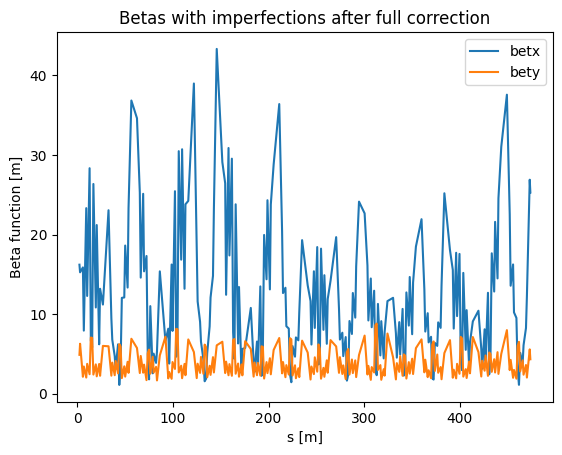

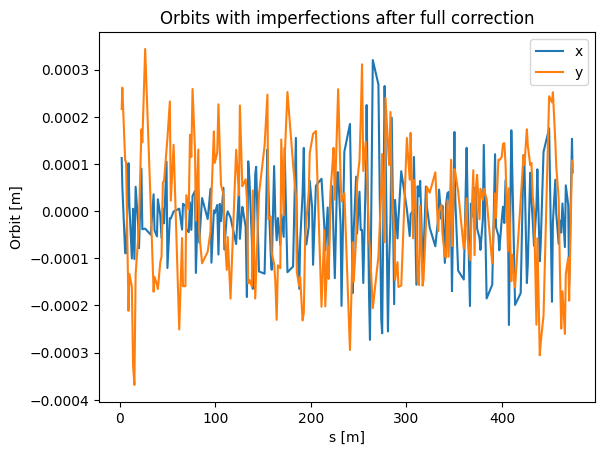

In [12]:
optics_after_correction = get_optics(structure, 
                                     imperfections_file="D:/PycharmProjects/SKIF-Lattice-Analysis/imperfections_tables/imperfections_all_aligns.txt", 
                                     file_with_kicks="D:/PycharmProjects/SKIF-Lattice-Analysis/stren1.out",
                                     file_with_matching_results="D:/PycharmProjects/SKIF-Lattice-Analysis/match_res1.txt",
                                     verbose=True)

plot_optics(optics_after_correction, params_to_show="beta", title="Betas with imperfections after full correction")
plt.show()

plot_optics(optics_after_correction, params_to_show="orbit", title="Orbits with imperfections after full correction")
plt.show()

 76%|█████████████████████████████████████████████████████                 | 500009/659468 [00:01<00:00, 396708.68it/s]
143it [00:00, ?it/s]


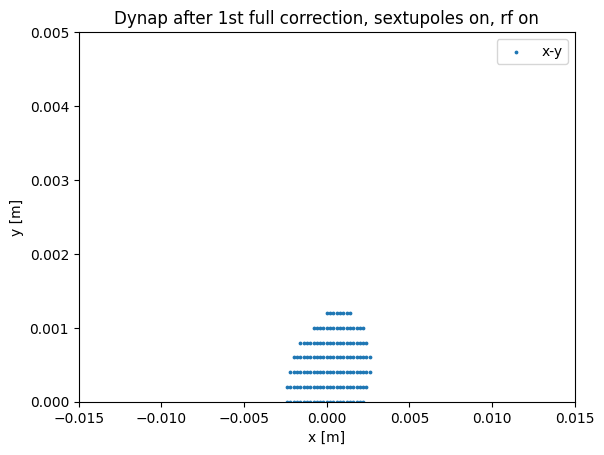

In [13]:
params = {"x": "m",
          "y": "m"}
tab_after_matching = read_tracking_file("tracking_data/trackingXY_norad_allAligns_kicksOn_matchedOn_1000one.txt", unlost_only=True)
plot_dynap(tab_after_matching, params, title="Dynap after 1st full correction, sextupoles on, rf on", plot_name="x-y", x_limits=[-0.015, 0.015], y_limits=[0, 0.005])
plt.show()

## 2nd Matching

100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [00:17<00:00,  2.89s/it]


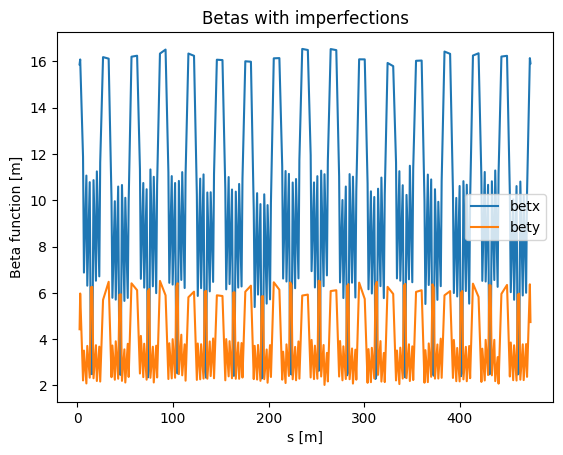

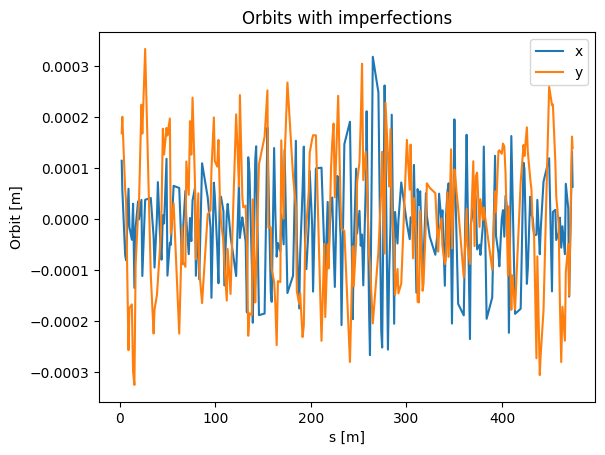

In [27]:
steps_for_matching = {"k1": 1e-3, "kick": 1e-4, "k1s": 1e-3}
optics_matched, match_res = match_optics(structure, 
                                         aligns=align_errs, 
                                         target_vars=["betx", "bety", "dx"], 
                                         target_optical_funcs=init_optics, 
                                         elem_and_params_to_match=elems_for_matching, 
                                         param_steps=steps_for_matching, 
                                         algorithms=["lmdif"], 
                                         file_with_kicks="D:/PycharmProjects/SKIF-Lattice-Analysis/stren1.out", 
                                         verbose=True, 
                                         save_matching=False,
                                         file_with_matching_results="D:/PycharmProjects/SKIF-Lattice-Analysis/match_res2.txt")

plot_optics(optics_matched, params_to_show="beta", title="Betas with imperfections")
plt.show()

plot_optics(optics_matched, params_to_show="orbit", title="Orbits with imperfections")
plt.show()

## Optics after orbit and 2nd structure correction, sextupoles on, rf on

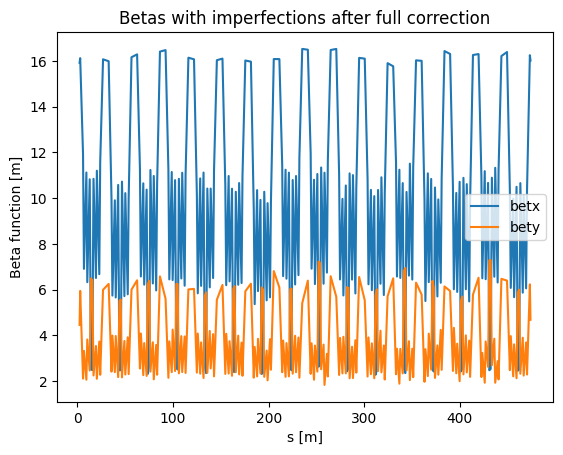

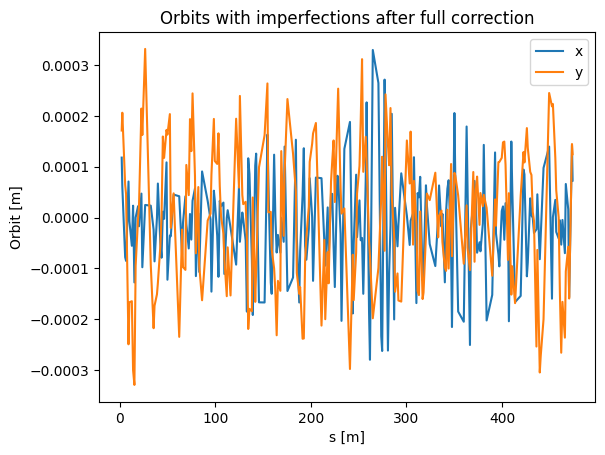

In [30]:
optics_after_correction = get_optics(structure, 
                                     imperfections_file="D:/PycharmProjects/SKIF-Lattice-Analysis/imperfections_tables/imperfections_all_aligns.txt", 
                                     file_with_kicks="D:/PycharmProjects/SKIF-Lattice-Analysis/stren1.out",
                                     file_with_matching_results="D:/PycharmProjects/SKIF-Lattice-Analysis/match_res2.txt",
                                     verbose=True)

plot_optics(optics_after_correction, params_to_show="beta", title="Betas with imperfections after full correction")
plt.show()

plot_optics(optics_after_correction, params_to_show="orbit", title="Orbits with imperfections after full correction")
plt.show()

 74%|███████████████████████████████████████████████████                  | 500009/675635 [00:01<00:00, 263887.90it/s]
139it [00:00, 69529.91it/s]


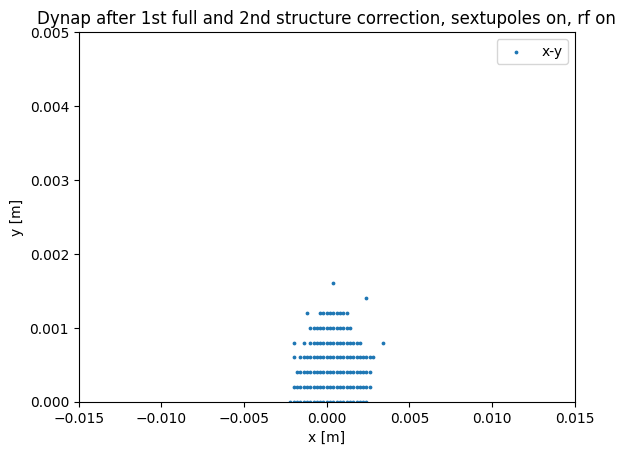

In [14]:
params = {"x": "m",
          "y": "m"}
tab_after_matching = read_tracking_file("tracking_data/trackingXY_norad_allAligns_kicksOn_matchedOn2_1000one.txt", unlost_only=True)
plot_dynap(tab_after_matching, params, title="Dynap after 1st full and 2nd structure correction, sextupoles on, rf on", plot_name="x-y", x_limits=[-0.015, 0.015], y_limits=[0, 0.005])
plt.show()

## Optics after 2nd orbit and structure correction, sextupoles on, rf on

## Optics correction wih LOCO

In [44]:
params_to_vary = {"k1l": {"Knobs": {i: {"Elements": [i]} for i in quads}}}
steps = {"k1l": 1e-5}

lattice_correction = LatticeCorrection(structure_nosext,
                                       orm,
                                       tunes,
                                       params_to_vary,
                                       steps,
                                       imperfections=align_errs)
lattice_correction.prepare_for_fit()
lattice_correction.svd_jacobian()
lattice_correction.choose_singular_values(len(params_to_vary))
lattice_correction.invert_jacobian()

for i in range(5):
    lattice_correction.fit()

100%|█████████████████████████████████████████████████████████████████████████████████| 99/99 [00:00<00:00, 418.21it/s]


TwissFailed: 

In [ ]:
old_aligns = lattice_correction.current_imperfections
lattice_corrected_optics = get_optics(structure_nosext, aligns=align_errs, old_aligns=old_aligns)

plt.plot(lattice_corrected_optics["x"], label='x')
plt.plot(lattice_corrected_optics["y"], label='y')
plt.legend()
plt.show()

plt.plot(lattice_corrected_optics["betx"], label='betx')
plt.plot(lattice_corrected_optics["bety"], label='bety')
plt.legend()
plt.show()

# Optics with all kind imperfections, sextupoles on

In [12]:
interim_optics = get_optics(structure, align_errs)
plot_optics(interim_optics, params_to_show="beta", title="Betas with imperfections")
plt.show()

plot_optics(interim_optics, params_to_show="orbit", title="Orbits with imperfections")
plt.show()

100%|█████████████████████████████████████████████████████████████████████████████| 1939/1939 [00:04<00:00, 445.82it/s]


Twiss Failed!


TypeError: 'NoneType' object is not subscriptable

100%|█████████████████████████████████████████████████████████████████████▉| 500009/500130 [00:01<00:00, 378507.72it/s]
3it [00:00, 2928.30it/s]


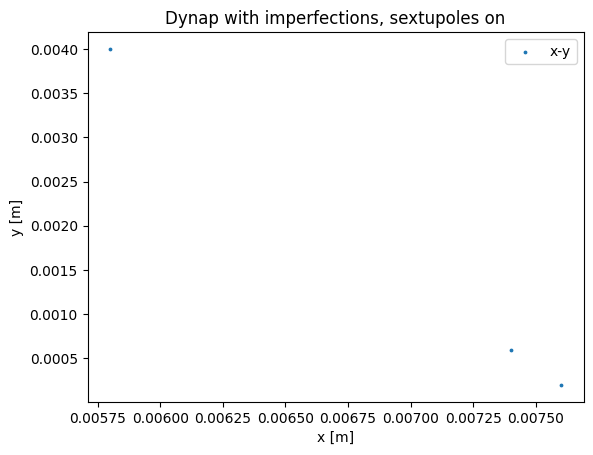

In [13]:
params = {"x": "m",
          "y": "m"}
tab_err = read_tracking_file("tracking_data/tracking_xy_norad_1000one.txt", unlost_only=True)
plot_dynap(tab_err, params, title="Dynap with imperfections, sextupoles on", plot_name="x-y")
plt.show()

# Optics with dxdydpsi imperfections, sextupoles off

In [88]:
align_errs = create_err_table(["dx", "dy", "dpsi"], elems_with_errs)

In [89]:
interim_optics_nosext = get_optics(structure_nosext, align_errs)
plot_optics(interim_optics_nosext, params_to_show="beta", title="Betas with imperfections")
plt.show()

plot_optics(interim_optics_nosext, params_to_show="orbit", title="Orbits with imperfections")
plt.show()

RuntimeError: MAD-X has stopped working!

 15%|██████████▍                                                          | 500009/3299507 [00:01<00:08, 314669.07it/s]
1it [00:00, ?it/s]


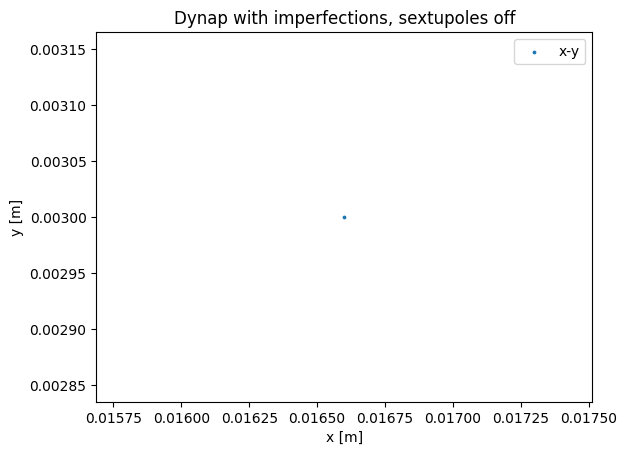

In [17]:
params = {"x": "m",
          "y": "m"}
tab_err = read_tracking_file("tracking_data/tracking_xy_nosext_norad_dxdydpsi_1000one.txt", unlost_only=True)
plot_dynap(tab_err, params, title="Dynap with imperfections, sextupoles off", plot_name="x-y")
plt.show()

# Optics with dxdydpsi imperfections, sextupoles on

In [18]:
interim_optics = get_optics(structure, align_errs)
plot_optics(interim_optics, params_to_show="beta", title="Betas with imperfections")
plt.show()

plot_optics(interim_optics, params_to_show="orbit", title="Orbits with imperfections")
plt.show()

100%|█████████████████████████████████████████████████████████████████████████████| 1939/1939 [00:04<00:00, 439.88it/s]


Twiss Failed!


TypeError: 'NoneType' object is not subscriptable

100%|█████████████████████████████████████████████████████████████████████▉| 500009/500209 [00:01<00:00, 404541.91it/s]
7it [00:00, 7000.51it/s]


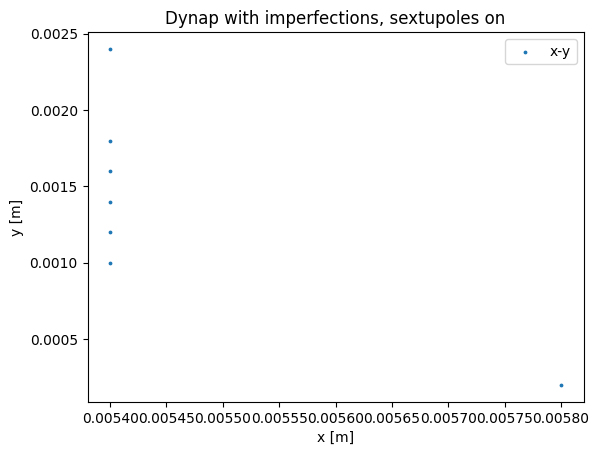

In [19]:
params = {"x": "m",
          "y": "m"}
tab_err = read_tracking_file("tracking_data/tracking_xy_norad_dxdydpsi_1000one.txt", unlost_only=True)
plot_dynap(tab_err, params, title="Dynap with imperfections, sextupoles on", plot_name="x-y")
plt.show()

In [34]:
import numpy as np

In [161]:
file = "D://PycharmProjects//LOCOinPython//structures//vepp4m//vepp4m_full_corrs_inj.seq"
structure_v4 = read_structure(file, energy=1.9)

Structure in the JSON format already exists


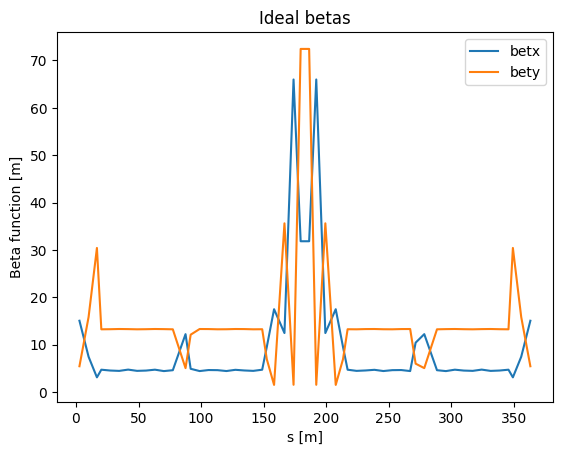

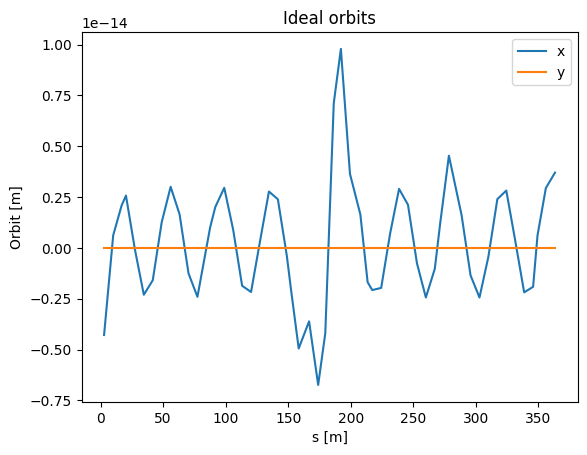

In [162]:
init_optics = get_optics(structure_v4)
plot_optics(init_optics, params_to_show="beta", title="Ideal betas")
plt.show()

plot_optics(init_optics, params_to_show="orbit", title="Ideal orbits")
plt.show()

In [178]:
imps = {'k1l': {'Knobs': 
                 {'f7': {'Elements': ['s1f.f7', 'n1f.f7', 's2f.f7', 'n2f.f7', 's3f.f7', 'n3f.f7', 's4f.f7', 'n4f.f7', 's5f.f7', 'n5f.f7', 's6f.f7', 'n6f.f7', 's7f.f7', 'n7f.f7', 's8f.f7', 'n8f.f7', 's9f.f7', 'n9f.f7', 's10f.f7', 'n10f.f7', 's11f.f7', 'n11f.f7', 's12f.f7', 'n12f.f7', 's13f.f7', 'n13f.f7', 's14f.f7', 'n14f.f7', 's15f.f7', 'n15f.f7', 's16f.f7', 'n16f.f7', 's17f.f7', 'n17f.f7']}, 'd7': {'Elements': ['s1d.d7', 'n1d.d7', 's2d.d7', 'n2d.d7', 's3d.d7', 'n3d.d7', 's4d.d7', 'n4d.d7', 's5d.d7', 'n5d.d7', 's6d.d7', 'n6d.d7', 's7d.d7', 'n7d.d7', 's8d.d7', 'n8d.d7', 's9d.d7', 'n9d.d7', 's10d.d7', 'n10d.d7', 's11d.d7', 'n11d.d7', 's12d.d7', 'n12d.d7', 's13d.d7', 'n13d.d7', 's14d.d7', 'n14d.d7', 's15d.d7', 'n15d.d7', 's16d.d7', 'n16d.d7']}},
                 'Values': [6.47360715e-04, -6.06255533e-04]}}

imps1 = {'k0l': {'Knobs': 
                 {'f7': {'Elements': ['s1f.f7', 'n1f.f7', 's2f.f7', 'n2f.f7', 's3f.f7', 'n3f.f7', 's4f.f7', 'n4f.f7', 's5f.f7', 'n5f.f7', 's6f.f7', 'n6f.f7', 's7f.f7', 'n7f.f7', 's8f.f7', 'n8f.f7', 's9f.f7', 'n9f.f7', 's10f.f7', 'n10f.f7', 's11f.f7', 'n11f.f7', 's12f.f7', 'n12f.f7', 's13f.f7', 'n13f.f7', 's14f.f7', 'n14f.f7', 's15f.f7', 'n15f.f7', 's16f.f7', 'n16f.f7', 's17f.f7', 'n17f.f7']}, 'd7': {'Elements': ['s1d.d7', 'n1d.d7', 's2d.d7', 'n2d.d7', 's3d.d7', 'n3d.d7', 's4d.d7', 'n4d.d7', 's5d.d7', 'n5d.d7', 's6d.d7', 'n6d.d7', 's7d.d7', 'n7d.d7', 's8d.d7', 'n8d.d7', 's9d.d7', 'n9d.d7', 's10d.d7', 'n10d.d7', 's11d.d7', 'n11d.d7', 's12d.d7', 'n12d.d7', 's13d.d7', 'n13d.d7', 's14d.d7', 'n14d.d7', 's15d.d7', 'n15d.d7', 's16d.d7', 'n16d.d7']}},
                 'Values': [-1.2360715e-05, 1.8055533e-05]}}

In [74]:
f7_k1l = 0.278605 * 1.11309 #* 34
d7_k1l = abs(-0.245194) * 1.11387 #* 32

print(6.47360715e-04 / f7_k1l)
print(-6.06255533e-04 / d7_k1l)

0.002087503217052908
-0.002219787336129255


In [173]:
qx0 = init_optics["qx"]
qy0 = init_optics["qy"]
betx0 = init_optics["betx"]
bety0 = init_optics["bety"]
print(qx0, qy0)

8.536883098609527 7.5767746293686224


In [68]:
qx = err_optics["qx"]
qy = err_optics["qy"]
betx = err_optics["betx"]
bety = err_optics["bety"]
print(delta_q(0.01, 0.01))
print(6.47360715e-04/f7_k1l * 100)

[[ 4.47360715e-05 -6.06255533e-05]
 [ 4.47360715e-05 -6.06255533e-05]]
0.2087503217052908


In [37]:
def delta_q(dqx, dqy, Ax1=39.4027250495963, Ax2=39.4027250495963, Ay1=-53.39789407610418, Ay2=-53.39789407610418):
    arr = np.array([[Ax1, Ax2], [Ay1, Ay2]])
    return np.linalg.pinv(arr).dot(np.array([dqx, dqy]))

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 53.15it/s]

0.012176832695129036 0.011893132569633202


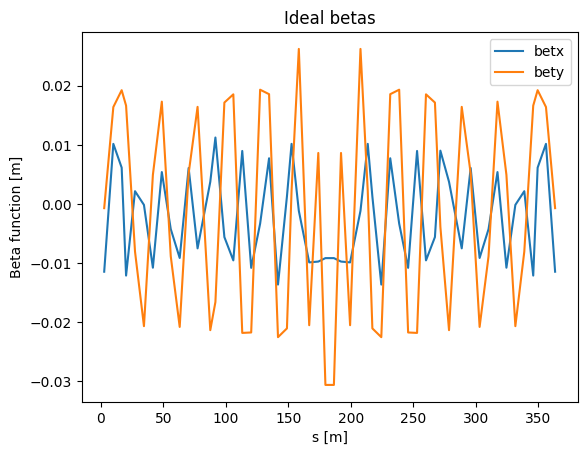

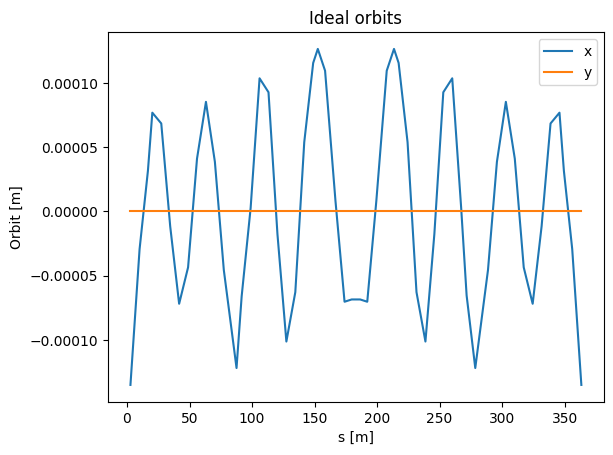

In [179]:
err_optics = get_optics(structure_v4, aligns=imps, old_aligns=imps1)
err_optics["betx"] = err_optics["betx"] / init_optics["betx"] - 1
err_optics["bety"] = err_optics["bety"] / init_optics["bety"] - 1
print(err_optics["qx"] - init_optics["qx"], err_optics["qy"] - init_optics["qy"])
plot_optics(err_optics, params_to_show="beta", title="Ideal betas")
plt.show()

plot_optics(err_optics, params_to_show="orbit", title="Ideal orbits")
plt.show()

In [109]:
afa = ['ma1.afa1', 'ma1.afa2', 'ma1.afa3', 'ma1.afa4', 'ma1.afa5', 'ma1.afa6', 'ma1.afa7', 'ma1.afa8', 'ma2.afa1', 'ma2.afa2', 'ma2.afa3', 'ma2.afa4', 'ma2.afa5', 'ma2.afa6', 'ma2.afa7', 'ma2.afa8', 'ma3.afa1', 'ma3.afa2', 'ma3.afa3', 'ma3.afa4', 'ma3.afa5', 'ma3.afa6', 'ma3.afa7', 'ma3.afa8', 'ma4.afa1', 'ma4.afa2', 'ma4.afa3', 'ma4.afa4', 'ma4.afa5', 'ma4.afa6', 'ma4.afa7', 'ma4.afa8', 'ma5.afa1', 'ma5.afa2', 'ma5.afa3', 'ma5.afa4', 'ma5.afa5', 'ma5.afa6', 'ma5.afa7', 'ma5.afa8', 'ma6.afa1', 'ma6.afa2', 'ma6.afa3', 'ma6.afa4', 'ma6.afa5', 'ma6.afa6', 'ma6.afa7', 'ma6.afa8', 'ma7.afa1', 'ma7.afa2', 'ma7.afa3', 'ma7.afa4', 'ma7.afa5', 'ma7.afa6', 'ma7.afa7', 'ma7.afa8', 'ma8.afa1', 'ma8.afa2', 'ma8.afa3', 'ma8.afa4', 'ma8.afa5', 'ma8.afa6', 'ma8.afa7', 'ma8.afa8', 'ma9.afa1', 'ma9.afa2', 'ma9.afa3', 'ma9.afa4', 'ma9.afa5', 'ma9.afa6', 'ma9.afa7', 'ma9.afa8', 'ma10.afa1', 'ma10.afa2', 'ma10.afa3', 'ma10.afa4', 'ma10.afa5', 'ma10.afa6', 'ma10.afa7', 'ma10.afa8', 'ma11.afa1', 'ma11.afa2', 'ma11.afa3', 'ma11.afa4', 'ma11.afa5', 'ma11.afa6', 'ma11.afa7', 'ma11.afa8', 'ma12.afa1', 'ma12.afa2', 'ma12.afa3', 'ma12.afa4', 'ma12.afa5', 'ma12.afa6', 'ma12.afa7', 'ma12.afa8', 'ma13.afa1', 'ma13.afa2', 'ma13.afa3', 'ma13.afa4', 'ma13.afa5', 'ma13.afa6', 'ma13.afa7', 'ma13.afa8', 'ma14.afa1', 'ma14.afa2', 'ma14.afa3', 'ma14.afa4', 'ma14.afa5', 'ma14.afa6', 'ma14.afa7', 'ma14.afa8', 'ma15.afa1', 'ma15.afa2', 'ma15.afa3', 'ma15.afa4', 'ma15.afa5', 'ma15.afa6', 'ma15.afa7', 'ma15.afa8', 'ma16.afa1', 'ma16.afa2', 'ma16.afa3', 'ma16.afa4', 'ma16.afa5', 'ma16.afa6', 'ma16.afa7', 'ma16.afa8']
afc = ['ma1.afc1', 'ma1.afc2', 'ma2.afc1', 'ma2.afc2', 'ma3.afc1', 'ma3.afc2', 'ma4.afc1', 'ma4.afc2', 'ma5.afc1', 'ma5.afc2', 'ma6.afc1', 'ma6.afc2', 'ma7.afc1', 'ma7.afc2', 'ma8.afc1', 'ma8.afc2', 'ma9.afc1', 'ma9.afc2', 'ma10.afc1', 'ma10.afc2', 'ma11.afc1', 'ma11.afc2', 'ma12.afc1', 'ma12.afc2', 'ma13.afc1', 'ma13.afc2', 'ma14.afc1', 'ma14.afc2', 'ma15.afc1', 'ma15.afc2', 'ma16.afc1', 'ma16.afc2']
imps = {'k1l': {'Knobs': 
                 {'afa': {'Elements': afa}, 'afc': {'Elements': afc}},
                 'Values': [1.97360715e-04, -5.06255533e-05]}}

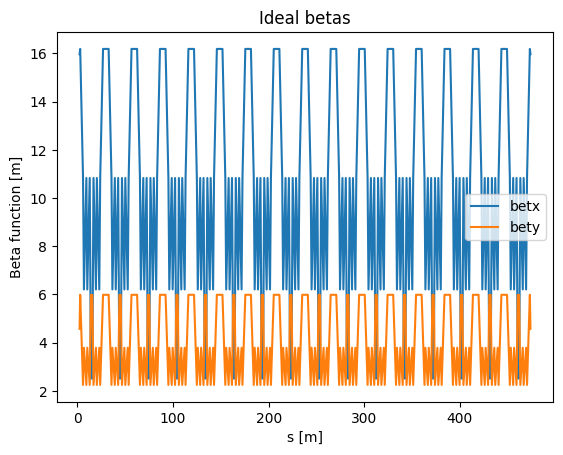

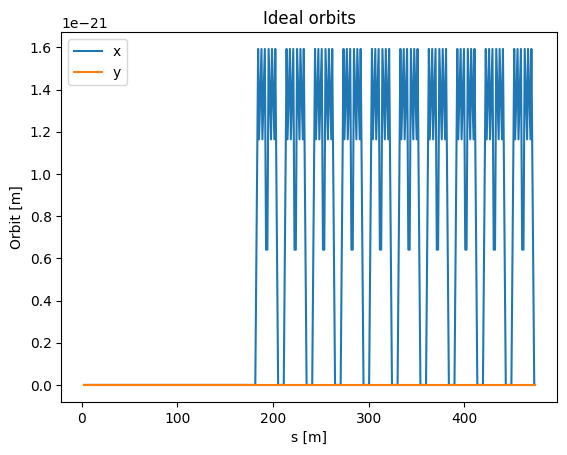

In [26]:
init_optics = get_optics(structure)
plot_optics(init_optics, params_to_show="beta", title="Ideal betas")
plt.show()

plot_optics(init_optics, params_to_show="orbit", title="Ideal orbits")
plt.show()

In [28]:
qx0 = init_optics["qx"]
qy0 = init_optics["qy"]
betx0 = init_optics["betx"]
bety0 = init_optics["bety"]
print(qx0, qy0)

50.806506630878744 18.840207862749764


In [48]:
qx = err_optics["qx"]
qy = err_optics["qy"]
betx = err_optics["betx"]
bety = err_optics["bety"]
print(delta_q(0.01, 0.01, Ax1=243.34, Ax2=48.668, Ay1=-54.47, Ay2=-10.894))

[2.92058324e-05 5.84116648e-06]


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.56it/s]


0.019654468980327522 -0.004483624271607312


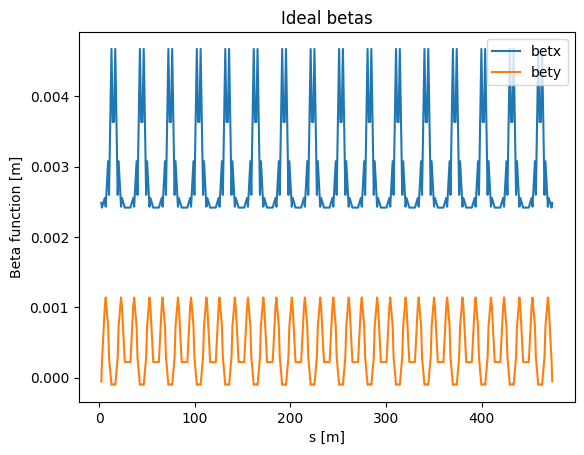

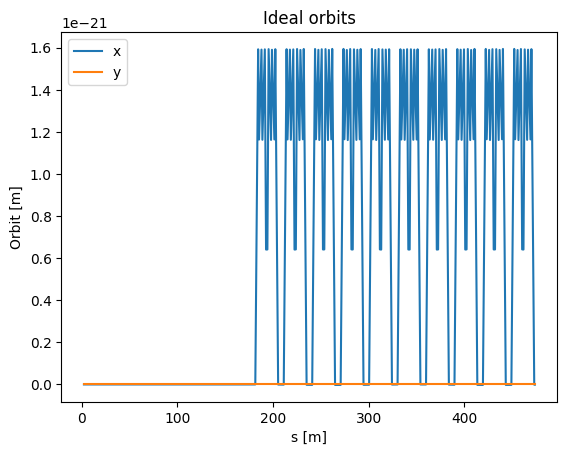

In [110]:
err_optics = get_optics(structure, aligns=imps)
err_optics["betx"] = err_optics["betx"] / init_optics["betx"] - 1
err_optics["bety"] = err_optics["bety"] / init_optics["bety"] - 1
print(err_optics["qx"] - init_optics["qx"], err_optics["qy"] - init_optics["qy"])
plot_optics(err_optics, params_to_show="beta", title="Ideal betas")
plt.show()

plot_optics(err_optics, params_to_show="orbit", title="Ideal orbits")
plt.show()

In [24]:
with open("D:\PycharmProjects\SKIF-Lattice-Analysis\imperfections_tables\imperfections_all_aligns_fix.txt", 'r') as f:
    dat1 = f.readlines()

with open("D:\PycharmProjects\SKIF-Lattice-Analysis\imperfections_tables\seed_41.txt", 'r') as f:
    dat2 = f.readlines()

In [36]:
missed = []
for i in dat1:
    i = i.split()[0]
    is_found = False
    for k in dat2:
        k = k.split()[0]
        if k == i:
            is_found = True
    if not is_found:
        missed.append(i)

In [ ]:
structure["elements"][i]["type"]

In [44]:
missed_ = {"monitor": [], "marker": [], "multipole": [], "other": [], "kicker": []}
for i in missed:
    i = i[1:-1].lower()
    if i in structure["elements"]:
        if structure["elements"][i]["type"] == "monitor":
            missed_["monitor"].append(i)
        elif structure["elements"][i]["type"] == "marker":
            missed_["marker"].append(i)
        elif structure["elements"][i]["type"] == "multipole":
            missed_["multipole"].append(i)
        elif structure["elements"][i]["type"] in ["hkicker", "vkicker"]:
            missed_["kicker"].append(i)
        else:
            missed_["other"].append(i)

In [45]:
from pprint import pprint

In [46]:
pprint(missed_)

{'kicker': ['ms1.kic3',
            'ma1.cma1.cy',
            'ma1.cma1.cx',
            'ma1.bma1.cx',
            'ma1.kic4',
            'ma1.sfa1.cy',
            'ma1.sfa1.cx',
            'ma1.sda1.cy',
            'ma1.sda1.cx',
            'ma1.sdb1.cy',
            'ma1.sdb1.cx',
            'ma1.sfb1.cy',
            'ma1.sfb1.cx',
            'ma1.sdc1.cy',
            'ma1.sdc1.cx',
            'ma1.sdd1.cy',
            'ma1.sdd1.cx',
            'ma1.sfc1.cy',
            'ma1.sfc1.cx',
            'ma1.cba1.cy',
            'ma1.cba1.cx',
            'ma1.sde1.cy',
            'ma1.sde1.cx',
            'ma1.sde2.cy',
            'ma1.sde2.cx',
            'ma1.sfc2.cy',
            'ma1.sfc2.cx',
            'ma1.sdd2.cy',
            'ma1.sdd2.cx',
            'ma1.sdc2.cy',
            'ma1.sdc2.cx',
            'ma1.sfb2.cy',
            'ma1.sfb2.cx',
            'ma1.cbb1.cy',
            'ma1.cbb1.cx',
            'ma1.sdb2.cy',
            'ma1.sdb2.cx',
       

# One period optics

Qx/Qy: 3.1600956091518784 / 1.0245742790593317
Coupling: 1.0 / 1.0 = 1.0


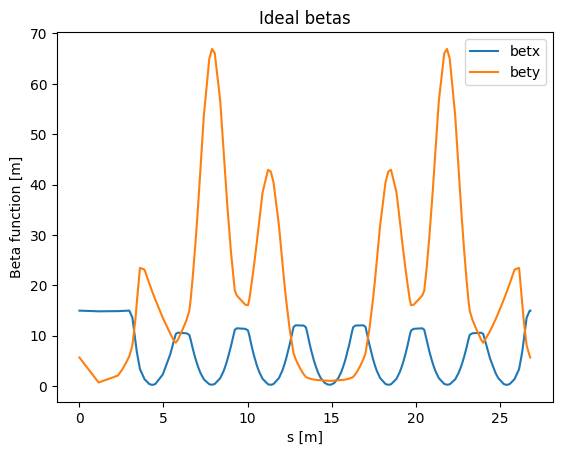

In [8]:
init_optics = get_optics(structure_one_period)
print(f"Qx/Qy: {init_optics['qx']} / {init_optics['qy']}")
print(f"Coupling: {init_optics['ey']} / {init_optics['ex']} = {init_optics['ey'] / init_optics['ex']}")
plot_optics(init_optics, params_to_show="beta_all", title="Ideal betas")
plt.show()

# plot_optics(init_optics, params_to_show="orbit", title="Ideal orbits")
# plt.show()

## Elements definition

In [8]:
structure = structure_one_period
elems_with_errs = []
for i in structure["elements"]:
    if structure["elements"][i]["type"] not in ["marker", "rfcavity"]:
        i_ = i.split(".")
        if len(i_) == 3:
            i_ = ".".join(i_[:-1])
            if i_ not in elems_with_errs:
                elems_with_errs.append(i_)
        else:
            elems_with_errs.append(i)
hcorrs = {i: {"type": "hkicker"} for i in structure["elements"] if structure["elements"][i]["type"] in ["hkicker"]}
vcorrs = {i: {"type": "vkicker"} for i in structure["elements"] if structure["elements"][i]["type"] in ["vkicker"]}
corrs = {"hkicker": hcorrs, "vkicker": vcorrs}
quads = [i for i in structure["elements"] if structure["elements"][i]["type"] in ["quadrupole"]]
bpms = [i for i in structure["elements"] if structure["elements"][i]["type"] in ["monitor"]]
mult_quads = [i for i in structure["elements"] if structure["elements"][i]["type"] in ["multipole"] and i.endswith(".cg")]
mult_skew_quads = [i for i in structure["elements"] if structure["elements"][i]["type"] in ["multipole"] and i.endswith(".cc")]

# elems_for_matching = {quad: "k1" for quad in quads}
# elems_for_matching.update({corr: "kick" for corr in hcorrs})
# elems_for_matching.update({corr: "kick" for corr in vcorrs})

elems_for_matching = {quad: "k1" for quad in quads + mult_quads}
elems_for_matching.update({skew_quad: "k1s" for skew_quad in mult_skew_quads})

structure["kick"] = corrs
structure["kick_total"] = corrs
print(len(elems_with_errs))

78


In [10]:
print(len(elems_for_matching))
print(elems_with_errs)

43
['ms1.pki2', 'ms1.kic3', 'ma1.pka1', 'ma1.qfa1', 'ma1.cma1', 'ma1.qda1', 'ma1.bma1', 'ma1.kic4', 'ma1.qfb1', 'ma1.pkb1', 'ma1.sfa1', 'ma1.afa1', 'ma1.pkc1', 'ma1.sda1', 'ma1.bda1', 'ma1.sdb1', 'ma1.afa2', 'ma1.pkd1', 'ma1.sfb1', 'ma1.afa3', 'ma1.pkc2', 'ma1.sdc1', 'ma1.bda2', 'ma1.sdd1', 'ma1.afa4', 'ma1.pkd2', 'ma1.sfc1', 'ma1.afc1', 'ma1.cba1', 'ma1.sde1', 'ma1.pke1', 'ma1.bdc1', 'ma1.bpc1', 'ma1.bdc2', 'ma1.pke2', 'ma1.sde2', 'ma1.afc2', 'ma1.sfc2', 'ma1.pkd3', 'ma1.afa5', 'ma1.sdd2', 'ma1.bda3', 'ma1.sdc2', 'ma1.pkc3', 'ma1.afa6', 'ma1.sfb2', 'ma1.pkd4', 'ma1.afa7', 'ma1.cbb1', 'ma1.sdb2', 'ma1.bda4', 'ma1.sda2', 'ma1.pkc4', 'ma1.afa8', 'ma1.sfa2', 'ma1.pkb2', 'ma1.qfb2', 'ma1.cbc1', 'ma1.bma2', 'ma1.qda2', 'ma1.cma2', 'ma1.qfa2', 'ma1.pka2', 'ms1.kic2', 'ms1.pki1', 'qqm03', 'qqm02', 'bd2l', 'bd2r', 'bf2', 'bf', 'bd', 'bfi', 'bdil', 'bdir', 'bil', 'bi', 'bir']


In [9]:
align_errs = create_err_table({"dx": 10e-6, "dy": 10e-6, "ds": 10e-6}, elems_with_errs, seed=42)
# align_errs = create_err_table(["dx", "dy", "dpsi"], elems_with_errs, seed=42)

## Optics with errors

In [10]:
interim_optics = get_optics(structure_one_period, aligns=align_errs, verbose=True)
plot_optics(interim_optics, params_to_show="beta_all", title="Betas with imperfections")
plt.show()

plot_optics(interim_optics, params_to_show="orbit", title="Orbits with imperfections")
plt.show()

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 15.37it/s]


Twiss Failed!


TypeError: 'NoneType' object is not subscriptable

## Optics with errors Sexts OFF

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 15.76it/s]

Qx/Qy: 3.160087374015438 / 1.024622255229038


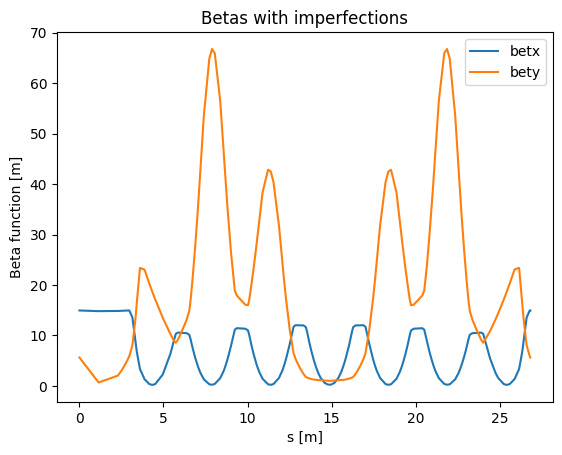

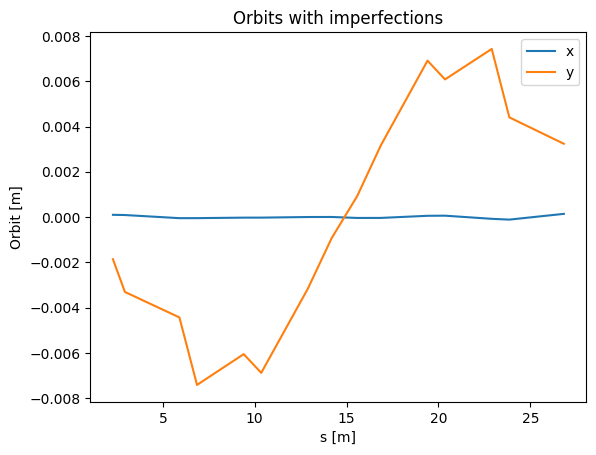

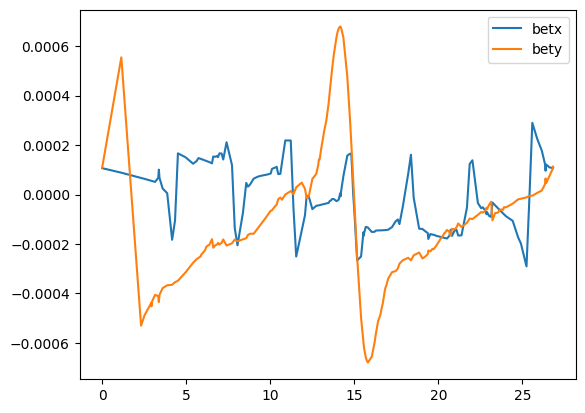

In [54]:
interim_optics = get_optics(structure_one_period_no_sext, aligns=align_errs, verbose=True)
print(f"Qx/Qy: {interim_optics['qx']} / {interim_optics['qy']}")
plot_optics(interim_optics, params_to_show="beta_all", title="Betas with imperfections")
plt.show()

plot_optics(interim_optics, params_to_show="orbit", title="Orbits with imperfections")
plt.show()

beatx = np.array(interim_optics["betx_all"]) / np.array(init_optics["betx_all"]) - 1
beaty = np.array(interim_optics["bety_all"]) / np.array(init_optics["bety_all"]) - 1
plt.plot(interim_optics["s_all"], beatx, label="betx")
plt.plot(interim_optics["s_all"], beaty, label="bety")
plt.legend()
plt.show()

## Orbit correction Sexts OFF

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 15.40it/s]

Qx/Qy: 3.1600852188368727 / 1.0246331370125425


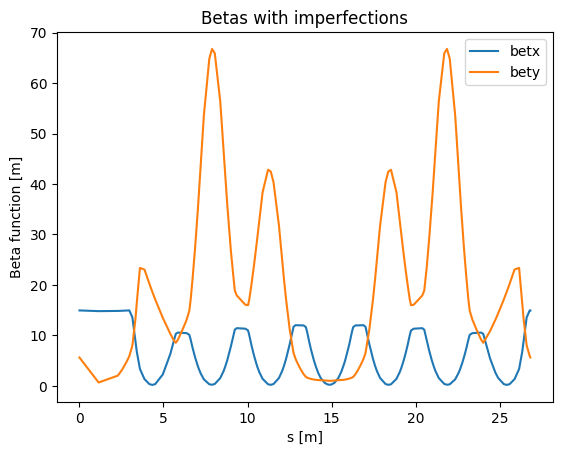

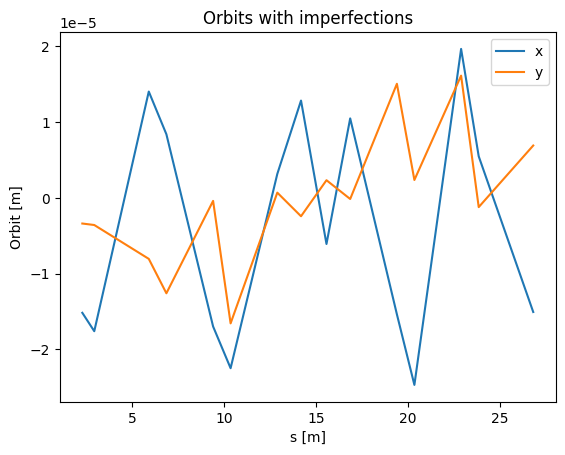

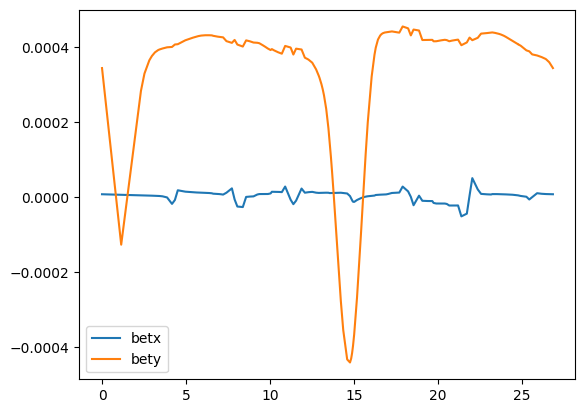

In [55]:
# res = correct_orbit(structure_one_period_no_sext, aligns=align_errs, planes=["x", "y"], algorithm="svd", verbose=True)

interim_optics_corr_orbit = get_optics(structure_one_period_no_sext, 
                                              aligns=align_errs, 
                                              file_with_kicks="D:/PycharmProjects/SKIF-Lattice-Analysis/stren.out", 
                                              verbose=True)
print(f"Qx/Qy: {interim_optics_corr_orbit['qx']} / {interim_optics_corr_orbit['qy']}")

plot_optics(interim_optics_corr_orbit, params_to_show="beta_all", title="Betas with imperfections")
plt.show()

plot_optics(interim_optics_corr_orbit, params_to_show="orbit", title="Orbits with imperfections")
plt.show()

beatx = np.array(interim_optics["betx_all"]) / np.array(interim_optics_corr_orbit["betx_all"]) - 1
beaty = np.array(interim_optics["bety_all"]) / np.array(interim_optics_corr_orbit["bety_all"]) - 1
plt.plot(interim_optics["s_all"], beatx, label="betx")
plt.plot(interim_optics["s_all"], beaty, label="bety")
plt.legend()
plt.show()

## Orbit correction Sexts ON

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 15.49it/s]

Qx/Qy: 3.160530165388304 / 1.029326727259702


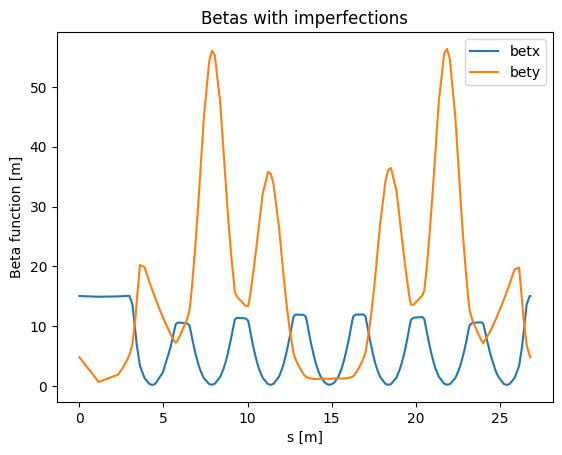

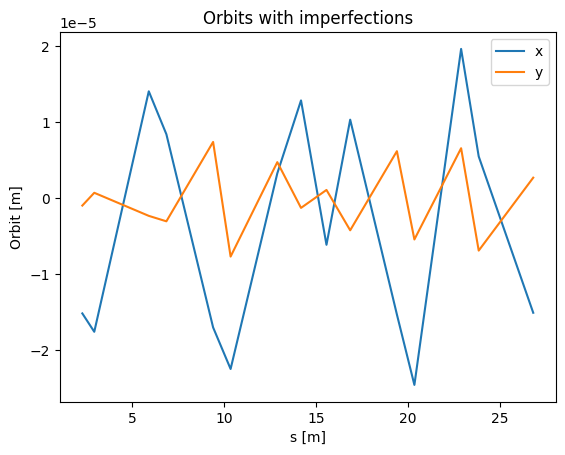

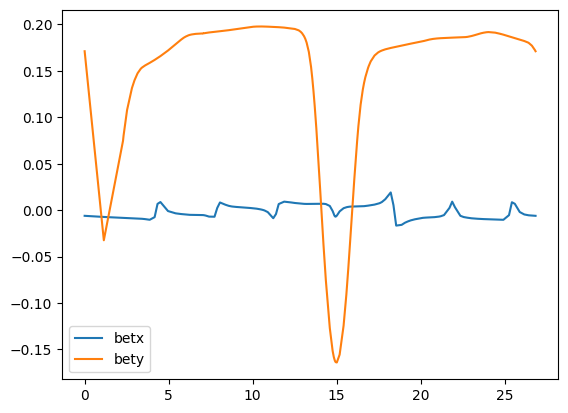

In [56]:
interim_optics_corr_orbit = get_optics(structure_one_period, 
                                              aligns=align_errs, 
                                              file_with_kicks="D:/PycharmProjects/SKIF-Lattice-Analysis/stren.out", 
                                              verbose=True)
print(f"Qx/Qy: {interim_optics_corr_orbit['qx']} / {interim_optics_corr_orbit['qy']}")

plot_optics(interim_optics_corr_orbit, params_to_show="beta_all", title="Betas with imperfections")
plt.show()

plot_optics(interim_optics_corr_orbit, params_to_show="orbit", title="Orbits with imperfections")
plt.show()

beatx = np.array(interim_optics["betx_all"]) / np.array(interim_optics_corr_orbit["betx_all"]) - 1
beaty = np.array(interim_optics["bety_all"]) / np.array(interim_optics_corr_orbit["bety_all"]) - 1
plt.plot(interim_optics["s_all"], beatx, label="betx")
plt.plot(interim_optics["s_all"], beaty, label="bety")
plt.legend()
plt.show()

## Matching

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 15.55it/s]


Qx/Qy: 3.1612793328728617 / 1.0241092186767178


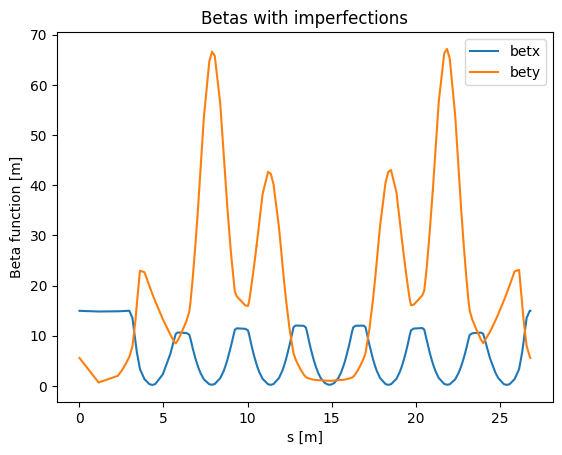

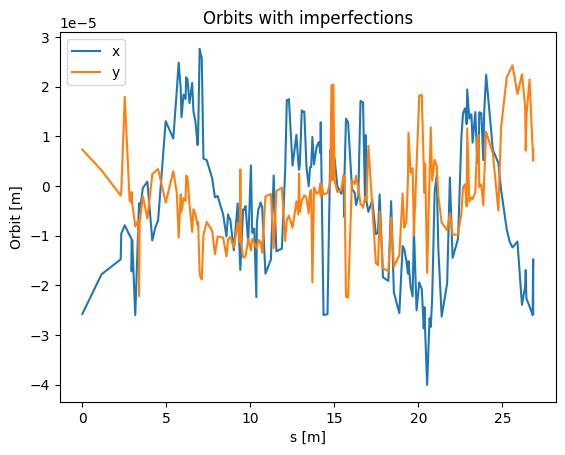

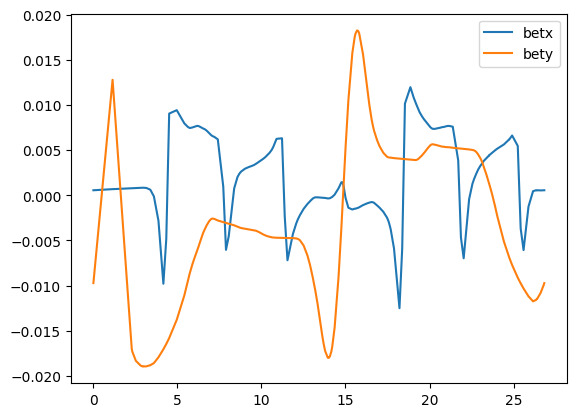

In [14]:
steps_for_matching = {"k1": 1e-3, "kick": 1e-4, "k1s": 1e-3}
interim_optics_matched, match_res = match_optics(structure_one_period, 
                                                        aligns=align_errs, 
                                                        target_vars=["betx", "bety", "dx"], 
                                                        target_optical_funcs=init_optics, 
                                                        elem_and_params_to_match=elems_for_matching, 
                                                        param_steps=steps_for_matching, 
                                                        algorithms=["lmdif"], 
                                                        file_with_kicks="D:/PycharmProjects/SKIF-Lattice-Analysis/stren.out", 
                                                        verbose=True, 
                                                        save_matching=False, 
                                                        file_to_save=None)
print(f"Qx/Qy: {interim_optics_matched['qx']} / {interim_optics_matched['qy']}")

plot_optics(interim_optics_matched, params_to_show="beta_all", title="Betas with imperfections")
plt.show()

plot_optics(interim_optics_matched, params_to_show="orbit_all", title="Orbits with imperfections")
plt.show()

beatx = np.array(interim_optics_matched["betx_all"]) / np.array(init_optics["betx_all"]) - 1
beaty = np.array(interim_optics_matched["bety_all"]) / np.array(init_optics["bety_all"]) - 1
plt.plot(interim_optics_matched["s_all"], beatx, label="betx")
plt.plot(interim_optics_matched["s_all"], beaty, label="bety")
plt.legend()
plt.show()